# D*Lite algoritm
source: 

Youtube video from "MIT OpenCourseWare" --- "Advanced 1. Incremental Path Planning"
https://youtu.be/_4u9W1xOuts?si=YHlAKIvOsC5xRQcm





In order to find the optimal path from start to goal and avoiding obstacles, we decided to implement the D*Lite algorithm.

The D* Lite is a pathfinding and replanning algorithm that operates in dynamic environments. 
D* Lite is able to efficiently handle changes in the environment  Instead of re-evaluating the entire path when there is a change, D* Lite focuses on evaluating and updating only the portions of the path affected by the change, making it computationally efficient for real-time applications.

In contrary to the A* algorithm, it computes the path from the goal to the start. This is because the start changes but the goal doesn't. So the gScore of the nodes doesn't change as often. 

Another difference is that the fScore isn't calculated anymore. The Key is now the value that tells which is the best node to investigate next. 

the algorithm can be found in the source video at 45'25. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import GlobalNavHelper as GH


%matplotlib inline

The cell below defines a function that will allows us to plot the map 

In [2]:
def create_plot(max_val, ax=None):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,7))
    
    ax.clear()
    ax.set_title('D* Plan')
    major_ticks = np.arange(0, max_val+1, 10)
    minor_ticks = np.arange(0, max_val+1, 5)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

In the next cell we define the map and the obstacles that the robot will have to avoid. The free space is white and the occupied space is red

Text(0.5, 1.0, 'Map : free cells in white, occupied cells in red')

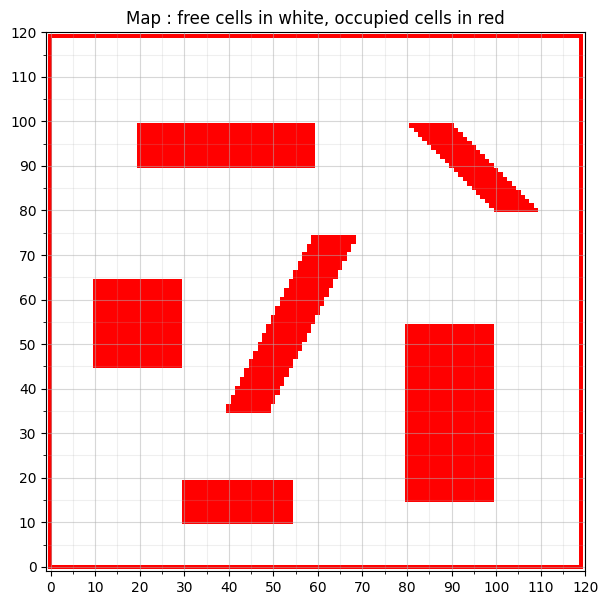

In [3]:
#Creating the grid

max_val = 120 # Size of the map

fig, ax = create_plot(max_val)

# Creating the occupancy grid

data = np.zeros((max_val,max_val)) # Create an empty grid, with larger dimaensions than max_value to allow the convolution
for i in range(max_val): #Border
    data[i,0]=1
    data[i,max_val-1]=1
    data[0,i]=1
    data[max_val-1,i]=1

for j in range(10):        #Obstacles
    for k in range (20):
        data[40+j+k,35+2*k]=1
        data[40+j+k,36+2*k]=1

for j in range(25):
    for k in range (10):
        data[30+j,10+k]=1

for j in range(40):
    for k in range (10):
        data[20+j,90+k]=1

for j in range(20):
    for k in range (20):
        data[10+j,45+k]=1

for j in range(20):
    for k in range (40):
        data[80+j,15+k]=1

for j in range(10):
    for k in range (20):
        data[100+j-k,80+k]=1


cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

# Converting the obstacles values into occupied and free cells
limit = 0 
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

# Displaying the map
ax.imshow(occupancy_grid.transpose(), cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red")


Now, let's "simulate" some changes in the map. We will create two new maps based on the previous one, and we will add one obstacle at the beginning and one at the end

In [4]:
# Simulate a change in the map

data_sim = data.copy()

for j in range(10):        #Obstacle at the beginning
    for k in range (2):
        data_sim[30+j,45+k-j]=1

# Converting the obstacles values into occupied and free cells
limit = 0 
occupancy_grid_sim = data_sim.copy()
occupancy_grid_sim[data_sim>limit] = 1
occupancy_grid_sim[data_sim<=limit] = 0




# Simulate a second change in the map

data_sim_plus = data_sim.copy()

for i in range(5):         #Obstacle at the end
    for j in range(5):
        data_sim_plus[75+i,95+j]=1

# Converting the obstacles values into occupied and free cells
limit = 0 
occupancy_grid_sim_plus = data_sim_plus.copy()
occupancy_grid_sim_plus[data_sim_plus>limit] = 1
occupancy_grid_sim_plus[data_sim_plus<=limit] = 0

Let's run the cell below and see the optimal path found by the alogritm.

Valid start node:  (10, 10)
Initialization phase
path found !


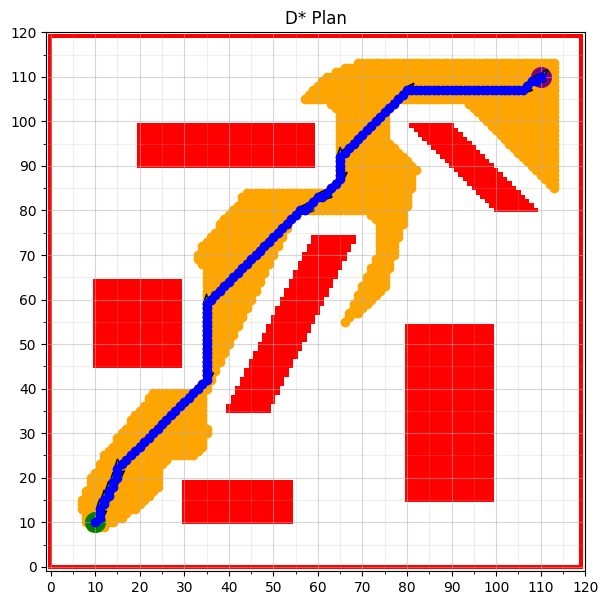

In [11]:
# Define the start and end goal
start = (10,10)
goal = (110,110)


path=GH.FindGlobalPath(start,goal,occupancy_grid,occupancy_grid)


In the next cell, we will see the re-evaluation of the optimal path after an obstacle is placed in front of it. 
The start node is purposely put too close to the obstacle (invalid) to illustrate the computation of a new valid start node that is close to the invalid one.

The yellow points correspond to the cells that needed to be (re-)computed to find the new path

Start node is not traversable, taking the available node closest to start node
Start node still not traversable, expanding calculation to neighborhood (level 2)
Valid start node:  (28, 38)
Update phase
path found !


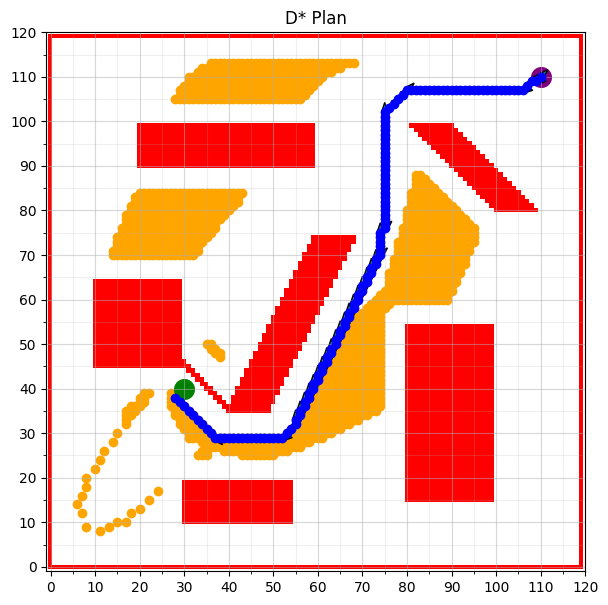

In [12]:
start = (30,40)
goal = (110,110)

path=GH.FindGlobalPath(start,goal,occupancy_grid_sim,occupancy_grid)

Now we simulate the detetion of a second obstacle near the goal. The D*Lite algorithm is able to efficiently avoid the obstacle, needing to update a few nodes.

Start node is not traversable, taking the available node closest to start node
Valid start node:  (76, 89)
Update phase
path found !


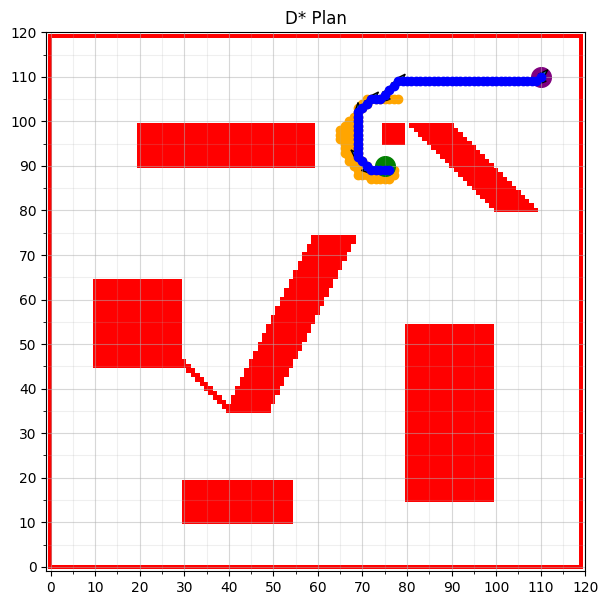

In [7]:
start = (75,90)
goal = (110,110)

path=GH.FindGlobalPath(start,goal,occupancy_grid_sim_plus,occupancy_grid_sim)